TO DO：
* 图文并茂
* 文字通俗易懂
* 标题夸张：一个用对抗验证解决样本分布变化的实例；建模之前请先确认一件事...
* 需要举例子解释 什么是样本分布变化？
* 将notebook上传到github
* 除了微信公众号，还需要在哪些渠道放文章：微博；Medium
* 可以投稿给 机器之心 这样的公众号吗？
* 图片要加简短注释

这个时候，交叉验证（Cross Validation）通常会失效，所以构建一个可靠的验证集（Validation），就非常重要。

如果构造的验证集（Validation）不可靠，我们就无法准确地评估模型的效果，进而无法评估改进模型的方法是否有效。

首先，我们如何确定样本的分布确实发生了变化呢？

Kaggle上通常用到的一个方法就是：对抗验证（Adversarial Validation）。

# 简介

在这篇notebook中，我们将通过一个实例去证明：「样本分布的变化」如何对模型产生影响。

我们将使用「对抗验证（Adversarial Validation）」来辨别这一问题

以及，用哪些方法可以修复

## 为什么「样本分布变化」会影响模型？

在真实的业务场景中，经常存在这个问题。

Kaggle上的比赛，通常不符合真实世界。

模型在训练样本保险不错，但是在应用样本不行。不是过拟合。

举例说明。

## 什么是对抗验证（Adversarial Validation）？

# 实例证明

## 数据

![Microsoft Malware Prediction](./input/Selection_020.png)

我将用一个实例来论证怎么使用对抗验证，以及在分布发生变化时做交叉验证所存在的问题。

用到的数据来自Kaggle上的[微软恶意软件比赛](https://www.kaggle.com/c/microsoft-malware-prediction/overview)比赛来说明。

这次比赛的目的是：预测电脑受到恶意软件攻击的概率。

因为这次比赛的 Train 和 Test 是根据时间划分的，所以Train 和 Test 的分布非常不同，很具有代表性。

## Import

In [1]:
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

# Memory management
import gc
gc.enable()

# Plot
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

因为数据集非常大，所以这里只选用2%的样本来说明问题。

In [6]:
# dtypes = {
#     'MachineIdentifier':                                    'category',
#     'ProductName':                                          'category',
#     'EngineVersion':                                        'category',
#     'AppVersion':                                           'category',
#     'AvSigVersion':                                         'category',
#     'IsBeta':                                               'int8',
#     'RtpStateBitfield':                                     'float16',
#     'IsSxsPassiveMode':                                     'int8',
#     'DefaultBrowsersIdentifier':                            'float32',
#     'AVProductStatesIdentifier':                            'float32',
#     'AVProductsInstalled':                                  'float16',
#     'AVProductsEnabled':                                    'float16',
#     'HasTpm':                                               'int8',
#     'CountryIdentifier':                                    'int16',
#     'CityIdentifier':                                       'float32',
#     'OrganizationIdentifier':                               'float16',
#     'GeoNameIdentifier':                                    'float16',
#     'LocaleEnglishNameIdentifier':                          'int16',
#     'Platform':                                             'category',
#     'Processor':                                            'category',
#     'OsVer':                                                'category',
#     'OsBuild':                                              'int16',
#     'OsSuite':                                              'int16',
#     'OsPlatformSubRelease':                                 'category',
#     'OsBuildLab':                                           'category',
#     'SkuEdition':                                           'category',
#     'IsProtected':                                          'float16',
#     'AutoSampleOptIn':                                      'int8',
#     'PuaMode':                                              'category',
#     'SMode':                                                'float16',
#     'IeVerIdentifier':                                      'float16',
#     'SmartScreen':                                          'category',
#     'Firewall':                                             'float16',
#     'UacLuaenable':                                         'float64',  # was 'float32'
#     'Census_MDC2FormFactor':                                'category',
#     'Census_DeviceFamily':                                  'category',
#     'Census_OEMNameIdentifier':                             'float32',  # was 'float16'
#     'Census_OEMModelIdentifier':                            'float32',
#     'Census_ProcessorCoreCount':                            'float16',
#     'Census_ProcessorManufacturerIdentifier':               'float16',
#     'Census_ProcessorModelIdentifier':                      'float32',  # was 'float16'
#     'Census_ProcessorClass':                                'category',
#     'Census_PrimaryDiskTotalCapacity':                      'float64',  # was 'float32'
#     'Census_PrimaryDiskTypeName':                           'category',
#     'Census_SystemVolumeTotalCapacity':                     'float64',  # was 'float32'
#     'Census_HasOpticalDiskDrive':                           'int8',
#     'Census_TotalPhysicalRAM':                              'float32',
#     'Census_ChassisTypeName':                               'category',
#     'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float32',  # was 'float16'
#     'Census_InternalPrimaryDisplayResolutionHorizontal':    'float32',  # was 'float16'
#     'Census_InternalPrimaryDisplayResolutionVertical':      'float32',  # was 'float16'
#     'Census_PowerPlatformRoleName':                         'category',
#     'Census_InternalBatteryType':                           'category',
#     'Census_InternalBatteryNumberOfCharges':                'float64',  # was 'float32'
#     'Census_OSVersion':                                     'category',
#     'Census_OSArchitecture':                                'category',
#     'Census_OSBranch':                                      'category',
#     'Census_OSBuildNumber':                                 'int16',
#     'Census_OSBuildRevision':                               'int32',
#     'Census_OSEdition':                                     'category',
#     'Census_OSSkuName':                                     'category',
#     'Census_OSInstallTypeName':                             'category',
#     'Census_OSInstallLanguageIdentifier':                   'float16',
#     'Census_OSUILocaleIdentifier':                          'int16',
#     'Census_OSWUAutoUpdateOptionsName':                     'category',
#     'Census_IsPortableOperatingSystem':                     'int8',
#     'Census_GenuineStateName':                              'category',
#     'Census_ActivationChannel':                             'category',
#     'Census_IsFlightingInternal':                           'float16',
#     'Census_IsFlightsDisabled':                             'float16',
#     'Census_FlightRing':                                    'category',
#     'Census_ThresholdOptIn':                                'float16',
#     'Census_FirmwareManufacturerIdentifier':                'float16',
#     'Census_FirmwareVersionIdentifier':                     'float32',
#     'Census_IsSecureBootEnabled':                           'int8',
#     'Census_IsWIMBootEnabled':                              'float16',
#     'Census_IsVirtualDevice':                               'float16',
#     'Census_IsTouchEnabled':                                'int8',
#     'Census_IsPenCapable':                                  'int8',
#     'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
#     'Wdft_IsGamer':                                         'float16',
#     'Wdft_RegionIdentifier':                                'float16',
#     'HasDetections':                                        'int8'
# }

# df_all = pd.read_csv('./input/train.csv.zip', dtype=dtypes) 
# df_all = df_all.sample(frac=0.02, random_state=123)
# df_all.to_csv('./input/train_sample.csv', index=False)

In [8]:
df_all = pd.read_csv('./input/train_sample.csv') 
df_all.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,586d40804b950d0376575fdf10ee89ae,win8defender,1.1.15100.1,4.18.1806.18062,1.273.520.0,0,7.0,0,NaN,53447.0,...,27767.0,1,NaN,0.0,0,0,0.0,1.0,15.0,1
1,65fb3fae2d37f90e6b3174592f2490a8,win8defender,1.1.15200.1,4.18.1807.18075,1.275.453.0,0,7.0,0,NaN,7945.0,...,14353.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
2,c23aa37fb69e00afe2668ed150dee1ea,win8defender,1.1.15100.1,4.18.1807.18075,1.273.689.0,0,7.0,0,NaN,53447.0,...,8941.0,1,NaN,0.0,0,0,0.0,1.0,1.0,1
3,cba75d6c4d9b6533591e94b9cb8a5df5,win8defender,1.1.15200.1,4.12.16299.15,1.275.483.0,0,7.0,0,NaN,68585.0,...,46589.0,1,NaN,0.0,0,0,0.0,1.0,7.0,1
4,149746364c6b763662d03e1f263029fd,win8defender,1.1.15200.1,4.18.1807.18075,1.275.215.0,0,7.0,0,NaN,53447.0,...,52530.0,0,NaN,0.0,0,0,0.0,NaN,NaN,0


AvSigVersionTimestamps是一个公开的数据集，通过和 AvSigVersion(XX版本号) 关联，我们可以粗略的得到样本的时间。

In [3]:
# IMPORT TIMESTAMP DICTIONARY
datedict = np.load('./input/AvSigVersionTimestamps.npy')
datedict = datedict[()]

df_all['Date'] = df_all['AvSigVersion'].map(datedict)
df_all = df_all.sort_values('Date')  

df_all.drop(['Date', 'MachineIdentifier'], axis=1, inplace=True)

## 数据清理

### 去掉无意义变量

如果变量中某个值的占比大于99%，我认为这些变量对模型没有意义

In [4]:
bad_cols = []
for col in df_all.columns:
    rate_train = df_all[col].value_counts(normalize=True, dropna=False).values[0]
    if rate_train > 0.99:
        bad_cols.append(col)

df_all = df_all.drop(bad_cols, axis=1)

print('Data Shape: ', df_all.shape)
print(bad_cols)

Data Shape:  (178430, 74)
['IsBeta', 'AutoSampleOptIn', 'PuaMode', 'UacLuaenable', 'Census_DeviceFamily', 'Census_ProcessorClass', 'Census_IsPortableOperatingSystem', 'Census_IsVirtualDevice']


### 定义数据类型

这里是通过EDA的方式，人工判断的变量类型。如果你对这次比赛的细节感兴趣，可以仔细看。

In [5]:
# 如果将categorical_columns_high_car 放到cartigorical里边会有什么问题？导致效果下降？训练时间很长？

In [6]:
true_numerical_columns = [
    'Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM', 'Census_InternalBatteryNumberOfCharges'
]

categorical_columns_high_car = [
    'Census_FirmwareVersionIdentifier', 'Census_OEMModelIdentifier',
    'AVProductStatesIdentifier', 'Census_FirmwareManufacturerIdentifier',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_OEMNameIdentifier', 'Census_ProcessorModelIdentifier',
    'CityIdentifier', 'DefaultBrowsersIdentifier', 'OsBuildLab'
]

categorical_columns = [
    c for c in df_all.columns
    if c not in (['HasDetections'] + true_numerical_columns +
                 categorical_columns_high_car)
]
print(categorical_columns)

['ProductName', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'RtpStateBitfield', 'IsSxsPassiveMode', 'AVProductsInstalled', 'AVProductsEnabled', 'HasTpm', 'CountryIdentifier', 'OrganizationIdentifier', 'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'Platform', 'Processor', 'OsVer', 'OsBuild', 'OsSuite', 'OsPlatformSubRelease', 'SkuEdition', 'IsProtected', 'SMode', 'IeVerIdentifier', 'SmartScreen', 'Firewall', 'Census_MDC2FormFactor', 'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier', 'Census_PrimaryDiskTypeName', 'Census_HasOpticalDiskDrive', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName', 'Census_InternalBatteryType', 'Census_OSVersion', 'Census_OSArchitecture', 'Census_OSBranch', 'Census_OSBuildNumber', 'Census_OSBuildRevision', 'Census_OSEdition', 'Census_OSSkuName', 'Census_OSInstallTypeName', 'Census_OSInstallLanguageIdentifier', 'Census_OSUILocaleIdentifier', 'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName', 'Census_ActivationChan

### 编码 -- Lebel Encoding

因为使用的模型是lightgbm，所以需要对categorical(类别类) 变量做编码，这里用的label encoding。

In [7]:
# 为什么要RESERVE 0，如果不，会如何？
def factor_data(df, col):
    df_labeled, _ = df[col].factorize(sort=True)
    # MAKE SMALLEST LABEL 1, RESERVE 0
    df_labeled += 1
    # MAKE NAN LARGEST LABEL
    df_labeled = np.where(df_labeled==0, df_labeled.max()+1, df_labeled)
    df[col] = df_labeled

In [8]:
for col in tqdm(categorical_columns + categorical_columns_high_car):
    factor_data(df_all, col) 

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 37.91it/s]


## 拆分测试集

拆分出一个测试集，用来评估我们validation的效果。

In [9]:
df_test = df_all.iloc[int(0.8*len(df_all)):, ]
df_train = df_all.iloc[:int(0.8*len(df_all)), ]

## 对抗验证（Adversarial Validatiion）

[对抗验证（Adversarial Validation）](http://fastml.com/adversarial-validation-part-one/)，是一种用来确认训练集（Train）和测试集（Test）的分布是否相似的方法。

它的本质是，构造一个分类模型，来预测样本是训练集或测试集的概率。

步骤：
* 将 Train 和 Test 合成一个数据集
* 定义新的标签：样本属于train还是test
* 构建模型拟合
* 观察模型效果
如果模型的AUC超过0.7，说明了 Train 和 Test 的分布存在较大的差异。

In [10]:
# 做ADV的时候，需要建立validation吗？迭代的次数需要通过early_stopping得到吗？
def adversarial_validation(df_train_, df_test_):   
    # labeling    
    df_train_['Test'] = 0
    df_test_['Test'] = 1   
    
    # concatenating 
    df_adv = pd.concat([df_train_, df_test_]).drop(['HasDetections'], axis=1)
    adv_data = lgb.Dataset(data=df_adv.drop('Test', axis=1), label=df_adv.loc[:,'Test'], free_raw_data=False, silent=True) # 这一步有什么用？
    
    del df_adv
    gc.collect()
    
    params = {
            'boosting_type': 'gbdt',
            'colsample_bytree': 1,
            'learning_rate': 0.3,
            'max_depth': 7,
            'min_child_samples': 20,
            'min_child_weight': 1,
            'min_split_gain': 0.0,
            'num_leaves': 31,
            'objective': 'binary',
            'random_state': 50,
            'reg_alpha': 0.0,
            'reg_lambda': 0.0,
            'subsample': 1.0,
            'subsample_for_bin': 200000,
            'subsample_freq': 0,
            'metric': 'cross_entropy',
            'num_threads': 8
        }

    clf = lgb.train(
                params=params,
                train_set=adv_data,
                num_boost_round=150,
                valid_sets=[adv_data],
                verbose_eval=False,
                categorical_feature = categorical_columns
            )
    
    adv_auc = roc_auc_score(adv_data.label, clf.predict(adv_data.data))
    print('Full adv AUC score %.6f' % adv_auc)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = adv_data.data.columns
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')

    return (fold_importance_df, adv_auc, clf, adv_data.data)

In [11]:
adv_rslt = adversarial_validation(df_train, df_test)

Full adv AUC score 1.000000


In [12]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout
#     plt.savefig('lgbm_importances01.png')

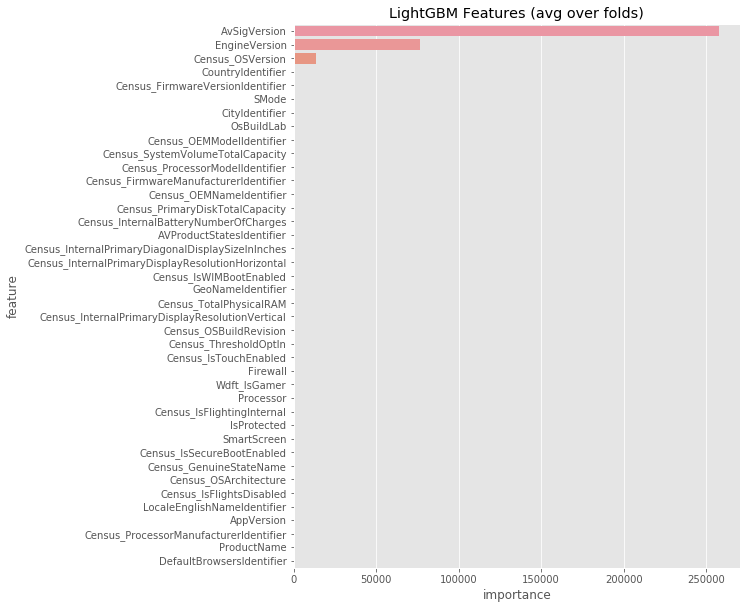

In [13]:
adv_feats_importance = adv_rslt[0]
display_importances(adv_feats_importance)

## 交叉验证（Cross Validation）

In [14]:
params = {
    'boosting_type': 'gbdt',
    'colsample_bytree': 1,
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_samples': 100,
    'min_child_weight': 1,
    'min_split_gain': 0.0,
    'num_leaves': 20,
    'objective': 'binary',
    'random_state': 50,
    'subsample': 1.0,
    'subsample_freq': 0,
    'metric': 'auc',
    'num_threads': 8
}

In [15]:
train_set = lgb.Dataset(
    df_train.drop('HasDetections', axis=1),
    label=df_train.loc[:, 'HasDetections'])

# Perform cross validation with early stopping
N_FOLDS = 5
cv_results = lgb.cv(
    params,
    train_set,
    num_boost_round=10000,
    nfold=N_FOLDS,
    categorical_feature=categorical_columns,
    early_stopping_rounds=200,
    verbose_eval=True,
    seed=42)

# Highest score
best = cv_results['auc-mean'][-1]

# Standard deviation of best score
best_std = cv_results['auc-stdv'][-1]

print(
    'The maximium ROC AUC in cross validation was {:.5f} with std of {:.5f}.'.
    format(best, best_std))

print('The ideal number of iterations was {}.'.format(
    len(cv_results['auc-mean'])))

[1]	cv_agg's auc: 0.673633 + 0.00264353
[2]	cv_agg's auc: 0.678882 + 0.0044727
[3]	cv_agg's auc: 0.6815 + 0.00346469
[4]	cv_agg's auc: 0.682948 + 0.00386172
[5]	cv_agg's auc: 0.684683 + 0.00415183
[6]	cv_agg's auc: 0.686288 + 0.00342958
[7]	cv_agg's auc: 0.687548 + 0.00316655
[8]	cv_agg's auc: 0.688257 + 0.0034225
[9]	cv_agg's auc: 0.689065 + 0.00333237
[10]	cv_agg's auc: 0.690081 + 0.00332501
[11]	cv_agg's auc: 0.690898 + 0.00355812
[12]	cv_agg's auc: 0.691641 + 0.00343357
[13]	cv_agg's auc: 0.692108 + 0.00359949
[14]	cv_agg's auc: 0.692707 + 0.00384956
[15]	cv_agg's auc: 0.693462 + 0.00350975
[16]	cv_agg's auc: 0.693576 + 0.00338896
[17]	cv_agg's auc: 0.693801 + 0.00324963
[18]	cv_agg's auc: 0.694156 + 0.00326456
[19]	cv_agg's auc: 0.694611 + 0.00338037
[20]	cv_agg's auc: 0.694983 + 0.00315375
[21]	cv_agg's auc: 0.695084 + 0.00318677
[22]	cv_agg's auc: 0.695499 + 0.00336445
[23]	cv_agg's auc: 0.695954 + 0.00323137
[24]	cv_agg's auc: 0.696359 + 0.00325667
[25]	cv_agg's auc: 0.69658 + 

In [17]:
params['n_estimators'] = len(cv_results['auc-mean'])

In [18]:
model = lgb.LGBMClassifier(**params)
model.fit(df_train.drop('HasDetections', axis=1), df_train.loc[:, 'HasDetections'])

# AUC
preds_test = model.predict_proba(df_test.drop('HasDetections', axis=1))[:, 1]
auc_test = roc_auc_score(df_test.loc[:, 'HasDetections'], preds_test)
print('The baseline model scores {:.5f} ROC AUC on the oot set.'.format(
    auc_test))

The baseline model scores 0.66980 ROC AUC on the oot set.


## 人工划分验证集

In [19]:
df_validation = df_train.iloc[int(0.8*len(df_train)):, ]
df_train = df_train.iloc[:int(0.8*len(df_train)), ]

In [20]:
dtrain = lgb.Dataset(data=df_train.drop('HasDetections', axis=1), 
                             label=df_train.loc[:, 'HasDetections'], 
                             free_raw_data=False, silent=True)

dvalid = lgb.Dataset(data=df_validation.drop('HasDetections', axis=1), 
                     label=df_validation.loc[:, 'HasDetections'], 
                     free_raw_data=False, silent=True)

In [21]:
params.pop('n_estimators', None)

83

In [22]:
clf = lgb.train(
            params=params,
            train_set=dtrain,
            num_boost_round=10000,
            valid_sets=[dtrain, dvalid],
            early_stopping_rounds=200,
            verbose_eval=True,
            categorical_feature = categorical_columns
        )

[1]	training's auc: 0.688663	valid_1's auc: 0.642369
Training until validation scores don't improve for 200 rounds.
[2]	training's auc: 0.694535	valid_1's auc: 0.649962
[3]	training's auc: 0.696651	valid_1's auc: 0.651748
[4]	training's auc: 0.698669	valid_1's auc: 0.653697
[5]	training's auc: 0.699434	valid_1's auc: 0.654084
[6]	training's auc: 0.701252	valid_1's auc: 0.654651
[7]	training's auc: 0.704317	valid_1's auc: 0.655619
[8]	training's auc: 0.706225	valid_1's auc: 0.65734
[9]	training's auc: 0.707367	valid_1's auc: 0.657409
[10]	training's auc: 0.708339	valid_1's auc: 0.658228
[11]	training's auc: 0.710424	valid_1's auc: 0.65975
[12]	training's auc: 0.711272	valid_1's auc: 0.659604
[13]	training's auc: 0.713813	valid_1's auc: 0.661753
[14]	training's auc: 0.714003	valid_1's auc: 0.66147
[15]	training's auc: 0.715192	valid_1's auc: 0.661742
[16]	training's auc: 0.7158	valid_1's auc: 0.661808
[17]	training's auc: 0.717848	valid_1's auc: 0.662201
[18]	training's auc: 0.719035	val

[300]	training's auc: 0.836427	valid_1's auc: 0.676322
[301]	training's auc: 0.836627	valid_1's auc: 0.676282
[302]	training's auc: 0.836838	valid_1's auc: 0.676244
[303]	training's auc: 0.837102	valid_1's auc: 0.676212
[304]	training's auc: 0.837276	valid_1's auc: 0.676166
[305]	training's auc: 0.837458	valid_1's auc: 0.676173
[306]	training's auc: 0.837517	valid_1's auc: 0.676152
[307]	training's auc: 0.837965	valid_1's auc: 0.676155
[308]	training's auc: 0.838165	valid_1's auc: 0.67619
[309]	training's auc: 0.838496	valid_1's auc: 0.676137
[310]	training's auc: 0.838724	valid_1's auc: 0.67617
[311]	training's auc: 0.838999	valid_1's auc: 0.676216
[312]	training's auc: 0.83928	valid_1's auc: 0.676236
[313]	training's auc: 0.839509	valid_1's auc: 0.676162
[314]	training's auc: 0.839693	valid_1's auc: 0.676181
[315]	training's auc: 0.839837	valid_1's auc: 0.676239
[316]	training's auc: 0.840141	valid_1's auc: 0.676317
[317]	training's auc: 0.840477	valid_1's auc: 0.676399
[318]	trainin

In [23]:
params['n_estimators'] = 363

In [24]:
model = lgb.LGBMClassifier(**params)
model.fit(df_train.drop('HasDetections', axis=1), df_train.loc[:, 'HasDetections'])

# AUC
preds_test = model.predict_proba(df_test.drop('HasDetections', axis=1))[:, 1]
auc_test = roc_auc_score(df_test.loc[:, 'HasDetections'], preds_test)
print('The baseline model scores {:.5f} ROC AUC on the oot set.'.format(
    auc_test))

The baseline model scores 0.67229 ROC AUC on the oot set.


# 结论

# 实验：categorical features with high cardinality

## 重新拆分测试集

In [26]:
df_test = df_all.iloc[int(0.8*len(df_all)):, ]
df_train = df_all.iloc[:int(0.8*len(df_all)), ]

In [27]:
categorical_columns = [
    c for c in df_all.columns
    if c not in (['HasDetections'] + true_numerical_columns)
]

print(categorical_columns)

['ProductName', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'RtpStateBitfield', 'IsSxsPassiveMode', 'DefaultBrowsersIdentifier', 'AVProductStatesIdentifier', 'AVProductsInstalled', 'AVProductsEnabled', 'HasTpm', 'CountryIdentifier', 'CityIdentifier', 'OrganizationIdentifier', 'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'Platform', 'Processor', 'OsVer', 'OsBuild', 'OsSuite', 'OsPlatformSubRelease', 'OsBuildLab', 'SkuEdition', 'IsProtected', 'SMode', 'IeVerIdentifier', 'SmartScreen', 'Firewall', 'Census_MDC2FormFactor', 'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier', 'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier', 'Census_ProcessorModelIdentifier', 'Census_PrimaryDiskTypeName', 'Census_HasOpticalDiskDrive', 'Census_ChassisTypeName', 'Census_InternalPrimaryDiagonalDisplaySizeInInches', 'Census_InternalPrimaryDisplayResolutionHorizontal', 'Census_InternalPrimaryDisplayResolutionVertical', 'Census_PowerPlatformRoleName', 'Census_InternalBatteryType

## 交叉验证 对比组

In [28]:
params = {
    'boosting_type': 'gbdt',
    'colsample_bytree': 1,
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_samples': 100,
    'min_child_weight': 1,
    'min_split_gain': 0.0,
    'num_leaves': 20,
    'objective': 'binary',
    'random_state': 50,
    'subsample': 1.0,
    'subsample_freq': 0,
    'metric': 'auc',
    'num_threads': 8
}

In [29]:
train_set = lgb.Dataset(
    df_train.drop('HasDetections', axis=1),
    label=df_train.loc[:, 'HasDetections'])

# Perform cross validation with early stopping
N_FOLDS = 5
cv_results = lgb.cv(
    params,
    train_set,
    num_boost_round=10000,
    nfold=N_FOLDS,
    categorical_feature=categorical_columns,
    early_stopping_rounds=200,
    verbose_eval=True,
    seed=42)

# Highest score
best = cv_results['auc-mean'][-1]

# Standard deviation of best score
best_std = cv_results['auc-stdv'][-1]

print(
    'The maximium ROC AUC in cross validation was {:.5f} with std of {:.5f}.'.
    format(best, best_std))

print('The ideal number of iterations was {}.'.format(
    len(cv_results['auc-mean'])))

[1]	cv_agg's auc: 0.66716 + 0.00179225
[2]	cv_agg's auc: 0.674429 + 0.00423191
[3]	cv_agg's auc: 0.682976 + 0.00388732
[4]	cv_agg's auc: 0.686857 + 0.00229685
[5]	cv_agg's auc: 0.688072 + 0.00234447
[6]	cv_agg's auc: 0.688948 + 0.00192203
[7]	cv_agg's auc: 0.69017 + 0.00263774
[8]	cv_agg's auc: 0.690893 + 0.00272522
[9]	cv_agg's auc: 0.691949 + 0.00248056
[10]	cv_agg's auc: 0.692518 + 0.00253189
[11]	cv_agg's auc: 0.693654 + 0.00265565
[12]	cv_agg's auc: 0.69447 + 0.00266003
[13]	cv_agg's auc: 0.69521 + 0.00285347
[14]	cv_agg's auc: 0.695984 + 0.00261841
[15]	cv_agg's auc: 0.696569 + 0.00279204
[16]	cv_agg's auc: 0.696828 + 0.00268797
[17]	cv_agg's auc: 0.697175 + 0.00254697
[18]	cv_agg's auc: 0.697493 + 0.00251981
[19]	cv_agg's auc: 0.698017 + 0.00253869
[20]	cv_agg's auc: 0.698371 + 0.00251246
[21]	cv_agg's auc: 0.698719 + 0.00272376
[22]	cv_agg's auc: 0.699083 + 0.00241366
[23]	cv_agg's auc: 0.699309 + 0.00238901
[24]	cv_agg's auc: 0.69962 + 0.00245354
[25]	cv_agg's auc: 0.699621 + 

In [30]:
params['n_estimators'] = len(cv_results['auc-mean'])

In [31]:
model = lgb.LGBMClassifier(**params)
model.fit(df_train.drop('HasDetections', axis=1), df_train.loc[:, 'HasDetections'])

# AUC
preds_test = model.predict_proba(df_test.drop('HasDetections', axis=1))[:, 1]
auc_test = roc_auc_score(df_test.loc[:, 'HasDetections'], preds_test)
print('The baseline model scores {:.5f} ROC AUC on the oot set.'.format(
    auc_test))

The baseline model scores 0.66051 ROC AUC on the oot set.


* 迭代次数减少：83到41
* Validation的AUC降低：0.70125到0.70060
* Test的AUC降低：0.66980到0.66051

## 人工划分验证集 对比组

In [32]:
df_validation = df_train.iloc[int(0.8*len(df_train)):, ]
df_train = df_train.iloc[:int(0.8*len(df_train)), ]

In [33]:
dtrain = lgb.Dataset(data=df_train.drop('HasDetections', axis=1), 
                             label=df_train.loc[:, 'HasDetections'], 
                             free_raw_data=False, silent=True)

dvalid = lgb.Dataset(data=df_validation.drop('HasDetections', axis=1), 
                     label=df_validation.loc[:, 'HasDetections'], 
                     free_raw_data=False, silent=True)

In [34]:
params.pop('n_estimators', None)

41

In [35]:
clf = lgb.train(
            params=params,
            train_set=dtrain,
            num_boost_round=10000,
            valid_sets=[dtrain, dvalid],
            early_stopping_rounds=200,
            verbose_eval=True,
            categorical_feature = categorical_columns
        )

[1]	training's auc: 0.684794	valid_1's auc: 0.635852
Training until validation scores don't improve for 200 rounds.
[2]	training's auc: 0.690245	valid_1's auc: 0.634689
[3]	training's auc: 0.700694	valid_1's auc: 0.65022
[4]	training's auc: 0.706851	valid_1's auc: 0.657809
[5]	training's auc: 0.709626	valid_1's auc: 0.659713
[6]	training's auc: 0.710876	valid_1's auc: 0.66102
[7]	training's auc: 0.712168	valid_1's auc: 0.661179
[8]	training's auc: 0.713381	valid_1's auc: 0.661427
[9]	training's auc: 0.715332	valid_1's auc: 0.661743
[10]	training's auc: 0.716372	valid_1's auc: 0.661889
[11]	training's auc: 0.717845	valid_1's auc: 0.662234
[12]	training's auc: 0.719415	valid_1's auc: 0.662036
[13]	training's auc: 0.721024	valid_1's auc: 0.663286
[14]	training's auc: 0.72252	valid_1's auc: 0.663306
[15]	training's auc: 0.724915	valid_1's auc: 0.664333
[16]	training's auc: 0.726774	valid_1's auc: 0.664861
[17]	training's auc: 0.728478	valid_1's auc: 0.665446
[18]	training's auc: 0.729655	v

In [36]:
params['n_estimators'] = 46

In [37]:
model = lgb.LGBMClassifier(**params)
model.fit(df_train.drop('HasDetections', axis=1), df_train.loc[:, 'HasDetections'])

# AUC
preds_test = model.predict_proba(df_test.drop('HasDetections', axis=1))[:, 1]
auc_test = roc_auc_score(df_test.loc[:, 'HasDetections'], preds_test)
print('The baseline model scores {:.5f} ROC AUC on the oot set.'.format(
    auc_test))

The baseline model scores 0.66146 ROC AUC on the oot set.


* 迭代次数减少：363到46
* Validation的AUC降低：0.676596到0.668609
* Test的AUC降低：0.67229到0.66146